In [1]:
import warnings
warnings.filterwarnings('ignore')
import re
from db.queries import get_sample_rows, get_user_forecast_data, row_to_config, get_predictive_data
import os

In [2]:
os.environ["ENV"] = "DEV"

In [3]:
ufm_df = get_user_forecast_data(databrick_task_id=70)
ufm_df.head()

,StartDate,EndDate,Parameters,Region,Status,ForecastMethodID,UserForecastMethodID,CustomerJSON,varJSON,Method,DatabrickID
0,2025-02-01,2030-02-28,"(1,1,1)(1,1,1,3)",EC,Completed,2,202,"{""PodId"": [""0220236410"",""2149064746"",""61834460...","{""VariableID"": [""OffPeakConsumption"",""PeakCons...",SARIMA,70


In [4]:
from etl.etl import *

In [5]:
all_prediction_columns = ["PeakConsumption", "StandardConsumption", "OffPeakConsumption","Block1Consumption", "Block2Consumption","Block3Consumption", "Block4Consumption",     "NonTOUConsumption"]

metadata = extract_metadata(ufm_df)
customer_ids = parse_json_column(ufm_df, "CustomerJSON")
variable_ids = parse_json_column(ufm_df, "varJSON", key="VariableID")
columns_mapping = generate_combinations(all_prediction_columns)

logging.info(f"Customer IDs: {customer_ids}")
logging.info(f"Variable IDs: {variable_ids}")
logging.info(f"✅ Total column combinations: {len(columns_mapping)}")

INFO:root:Generated 255 column combinations.
INFO:root:Customer IDs: ['9604489430', '7364254493', '7300242996', '6858004541', '0220236410', '2149064746', '6183446094', '6007397463', '8323845186', '6582636837']
INFO:root:Variable IDs: ['PeakConsumption', 'StandardConsumption', 'Block2Consumption', 'NonTOUConsumption', 'Block3Consumption', 'Block1Consumption', 'OffPeakConsumption', 'Block4Consumption']
INFO:root:✅ Total column combinations: 255


In [6]:
print(f"✅ Total combinations: {len(generate_combinations(all_prediction_columns))}\n")


INFO:root:Generated 255 column combinations.


✅ Total combinations: 255



In [7]:
selected_columns = find_matching_combination(columns_mapping, all_prediction_columns)

INFO:root:Exact match found for: frozenset({'PeakConsumption', 'StandardConsumption', 'Block2Consumption', 'NonTOUConsumption', 'Block3Consumption', 'Block1Consumption', 'OffPeakConsumption', 'Block4Consumption'})


In [8]:
if selected_columns:
    logging.info(f"Selected Columns: {selected_columns}")
else:
    logging.error("No matching columns found in AllVariables")

INFO:root:Selected Columns: ['ReportingMonth', 'CustomerID', 'PeakConsumption', 'StandardConsumption', 'OffPeakConsumption', 'Block1Consumption', 'Block2Consumption', 'Block3Consumption', 'Block4Consumption', 'NonTOUConsumption']


In [9]:
from dml.dml import *

In [10]:
# df = get_predictive_data(UFMID=202)
# df.head()

df = load_and_prepare_data("PredictiveInputDataSarima.csv")
df.head()

,UserForecastMethodID,PodID,CustomerID,TariffID,ReportingMonth,PeakConsumption,StandardConsumption,OffPeakConsumption,Block1Consumption,Block2Consumption,Block3Consumption,Block4Consumption,NonTOUConsumption
0,202,6582636837,5000072536,RURAINT,2022-04-01,1654.0,16818.0,18724.0,0.0,0.0,0.0,0.0,0.0
1,202,6582636837,5000072536,RURAINT,2022-05-01,4166.0,13214.0,41454.0,0.0,0.0,0.0,0.0,0.0
2,202,6582636837,5000072536,RURAINT,2022-06-01,1788.0,21644.0,23368.0,0.0,0.0,0.0,0.0,0.0
3,202,6582636837,5000072536,RURAINT,2022-07-01,9888.0,53348.0,71014.0,0.0,0.0,0.0,0.0,0.0
4,202,6582636837,5000072536,RURAINT,2022-08-01,6018.0,95022.0,83324.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# df.to_csv("PredictiveInputDataSARIMA.csv")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   UserForecastMethodID  194 non-null    int64  
 1   PodID                 194 non-null    object 
 2   CustomerID            194 non-null    object 
 3   TariffID              194 non-null    object 
 4   ReportingMonth        194 non-null    object 
 5   PeakConsumption       194 non-null    float64
 6   StandardConsumption   194 non-null    float64
 7   OffPeakConsumption    194 non-null    float64
 8   Block1Consumption     194 non-null    float64
 9   Block2Consumption     194 non-null    float64
 10  Block3Consumption     194 non-null    float64
 11  Block4Consumption     194 non-null    float64
 12  NonTOUConsumption     194 non-null    float64
dtypes: float64(8), int64(1), object(4)
memory usage: 19.8+ KB


In [12]:
row = ufm_df.iloc[0]
config = row_to_config(row)

In [18]:
config

ForecastConfig(forecast_method_id=2, forecast_method_name='SARIMA', model_parameters='(1,1,1)(1,1,1,3)', region='EC', status='Completed', user_forecast_method_id=202, start_date=datetime.date(2025, 2, 1), end_date=datetime.date(2030, 2, 28), databrick_id=70)

In [19]:
if df.empty:
    logging.error("🚫 DataFrame is empty. Check input filters or data source.")
else:
    customer_ids, pod_ids = get_unique_list_of_customer_and_pod(df)

    # These variables should come from user input / config
    StartDate = config.start_date
    EndDate = config.end_date
    Hyper_Parameters = config.model_parameters

    forecast_dates = get_forecast_range(StartDate, EndDate)
    arima_order, seasonal_order = extract_sarimax_params(Hyper_Parameters)

    # Extract actuals range
    latest_actual_date = df.index.max()
    logging.info(f"📍 Last actuals month in data: {latest_actual_date.strftime('%Y-%m')}")

INFO:root:🧮 Forecasting for 2 customers: ['5000072536', '8988616349']
INFO:root:📅 Forecast period: 2025-02-01 00:00:00 to 2030-02-01 00:00:00
INFO:root:📌 Parsed ARIMA Order: (1, 1, 1), Seasonal Order: (1, 1, 1, 3)


AttributeError: 'int' object has no attribute 'strftime'

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Select a small sample of customers for clearer plots
top_customers = df['CustomerID'].value_counts().head(4).index.tolist()
sample_df = df[df['CustomerID'].isin(top_customers)]
sample_df = df.reset_index()
# Melt the dataframe for easier time series plotting
melted_df = pd.melt(
   sample_df,
    id_vars=['CustomerID', 'ReportingMonth'],
    value_vars=[
        'PeakConsumption', 'StandardConsumption', 'OffPeakConsumption',
        'Block1Consumption', 'Block2Consumption', 'Block3Consumption',
        'Block4Consumption', 'NonTOUConsumption'
    ],
    var_name='ConsumptionType',
    value_name='kWh'
)
melted_df

,CustomerID,ReportingMonth,ConsumptionType,kWh
0,5000072536,2022-04-01,PeakConsumption,1654.0
1,5000072536,2022-05-01,PeakConsumption,4166.0
2,5000072536,2022-06-01,PeakConsumption,1788.0
3,5000072536,2022-07-01,PeakConsumption,9888.0
4,5000072536,2022-08-01,PeakConsumption,6018.0
...,...,...,...,...
1547,5000072536,2024-10-01,NonTOUConsumption,0.0
1548,5000072536,2024-11-01,NonTOUConsumption,0.0
1549,5000072536,2024-12-01,NonTOUConsumption,0.0
1550,5000072536,2025-01-01,NonTOUConsumption,0.0


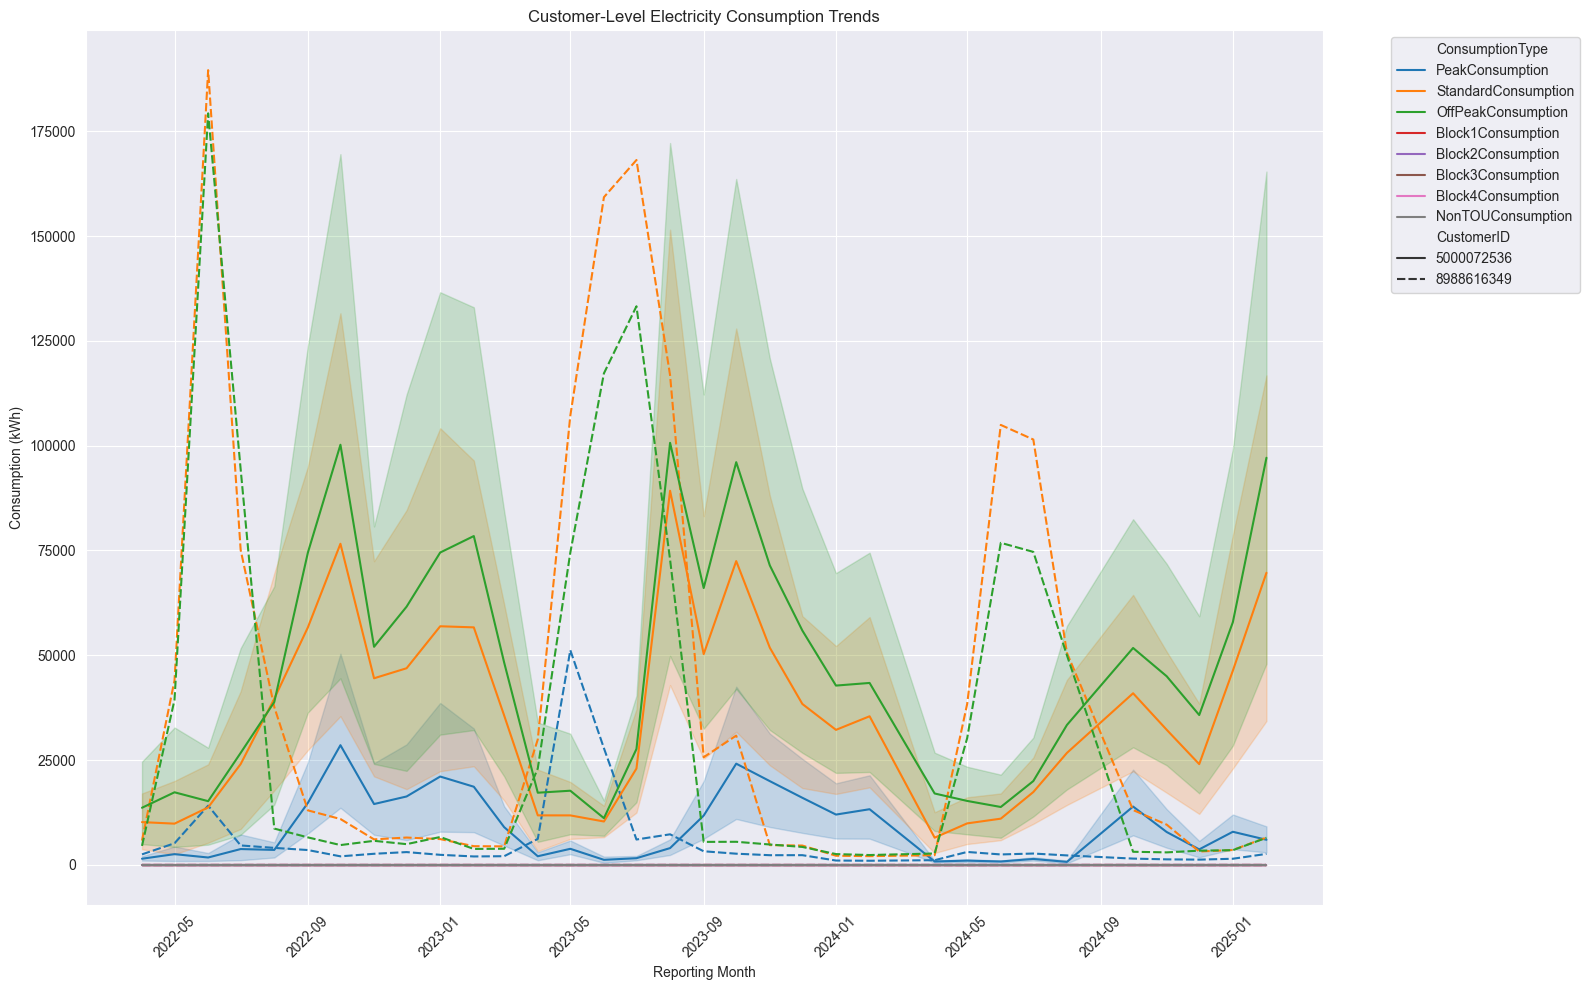

In [22]:
# Plot
plt.figure(figsize=(16, 10))
sns.lineplot(data=melted_df, x='ReportingMonth', y='kWh', hue='ConsumptionType', style='CustomerID')
plt.title("Customer-Level Electricity Consumption Trends")
plt.xlabel("Reporting Month")
plt.ylabel("Consumption (kWh)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

📊 Visualization: Customer-Level Electricity Consumption Trends
This chart shows how different types of electricity consumption evolve over time for a sample of top customers:

🧩 Insights:
Seasonal patterns are visible — especially in PeakConsumption and Block1Consumption.

Customer behavior varies — some use more off-peak or flat-rate (NonTOU) power.

Trends help you:

Choose which features to forecast.

Spot outliers or data quality issues.

Guide model segmentation (e.g., cluster by consumption type).

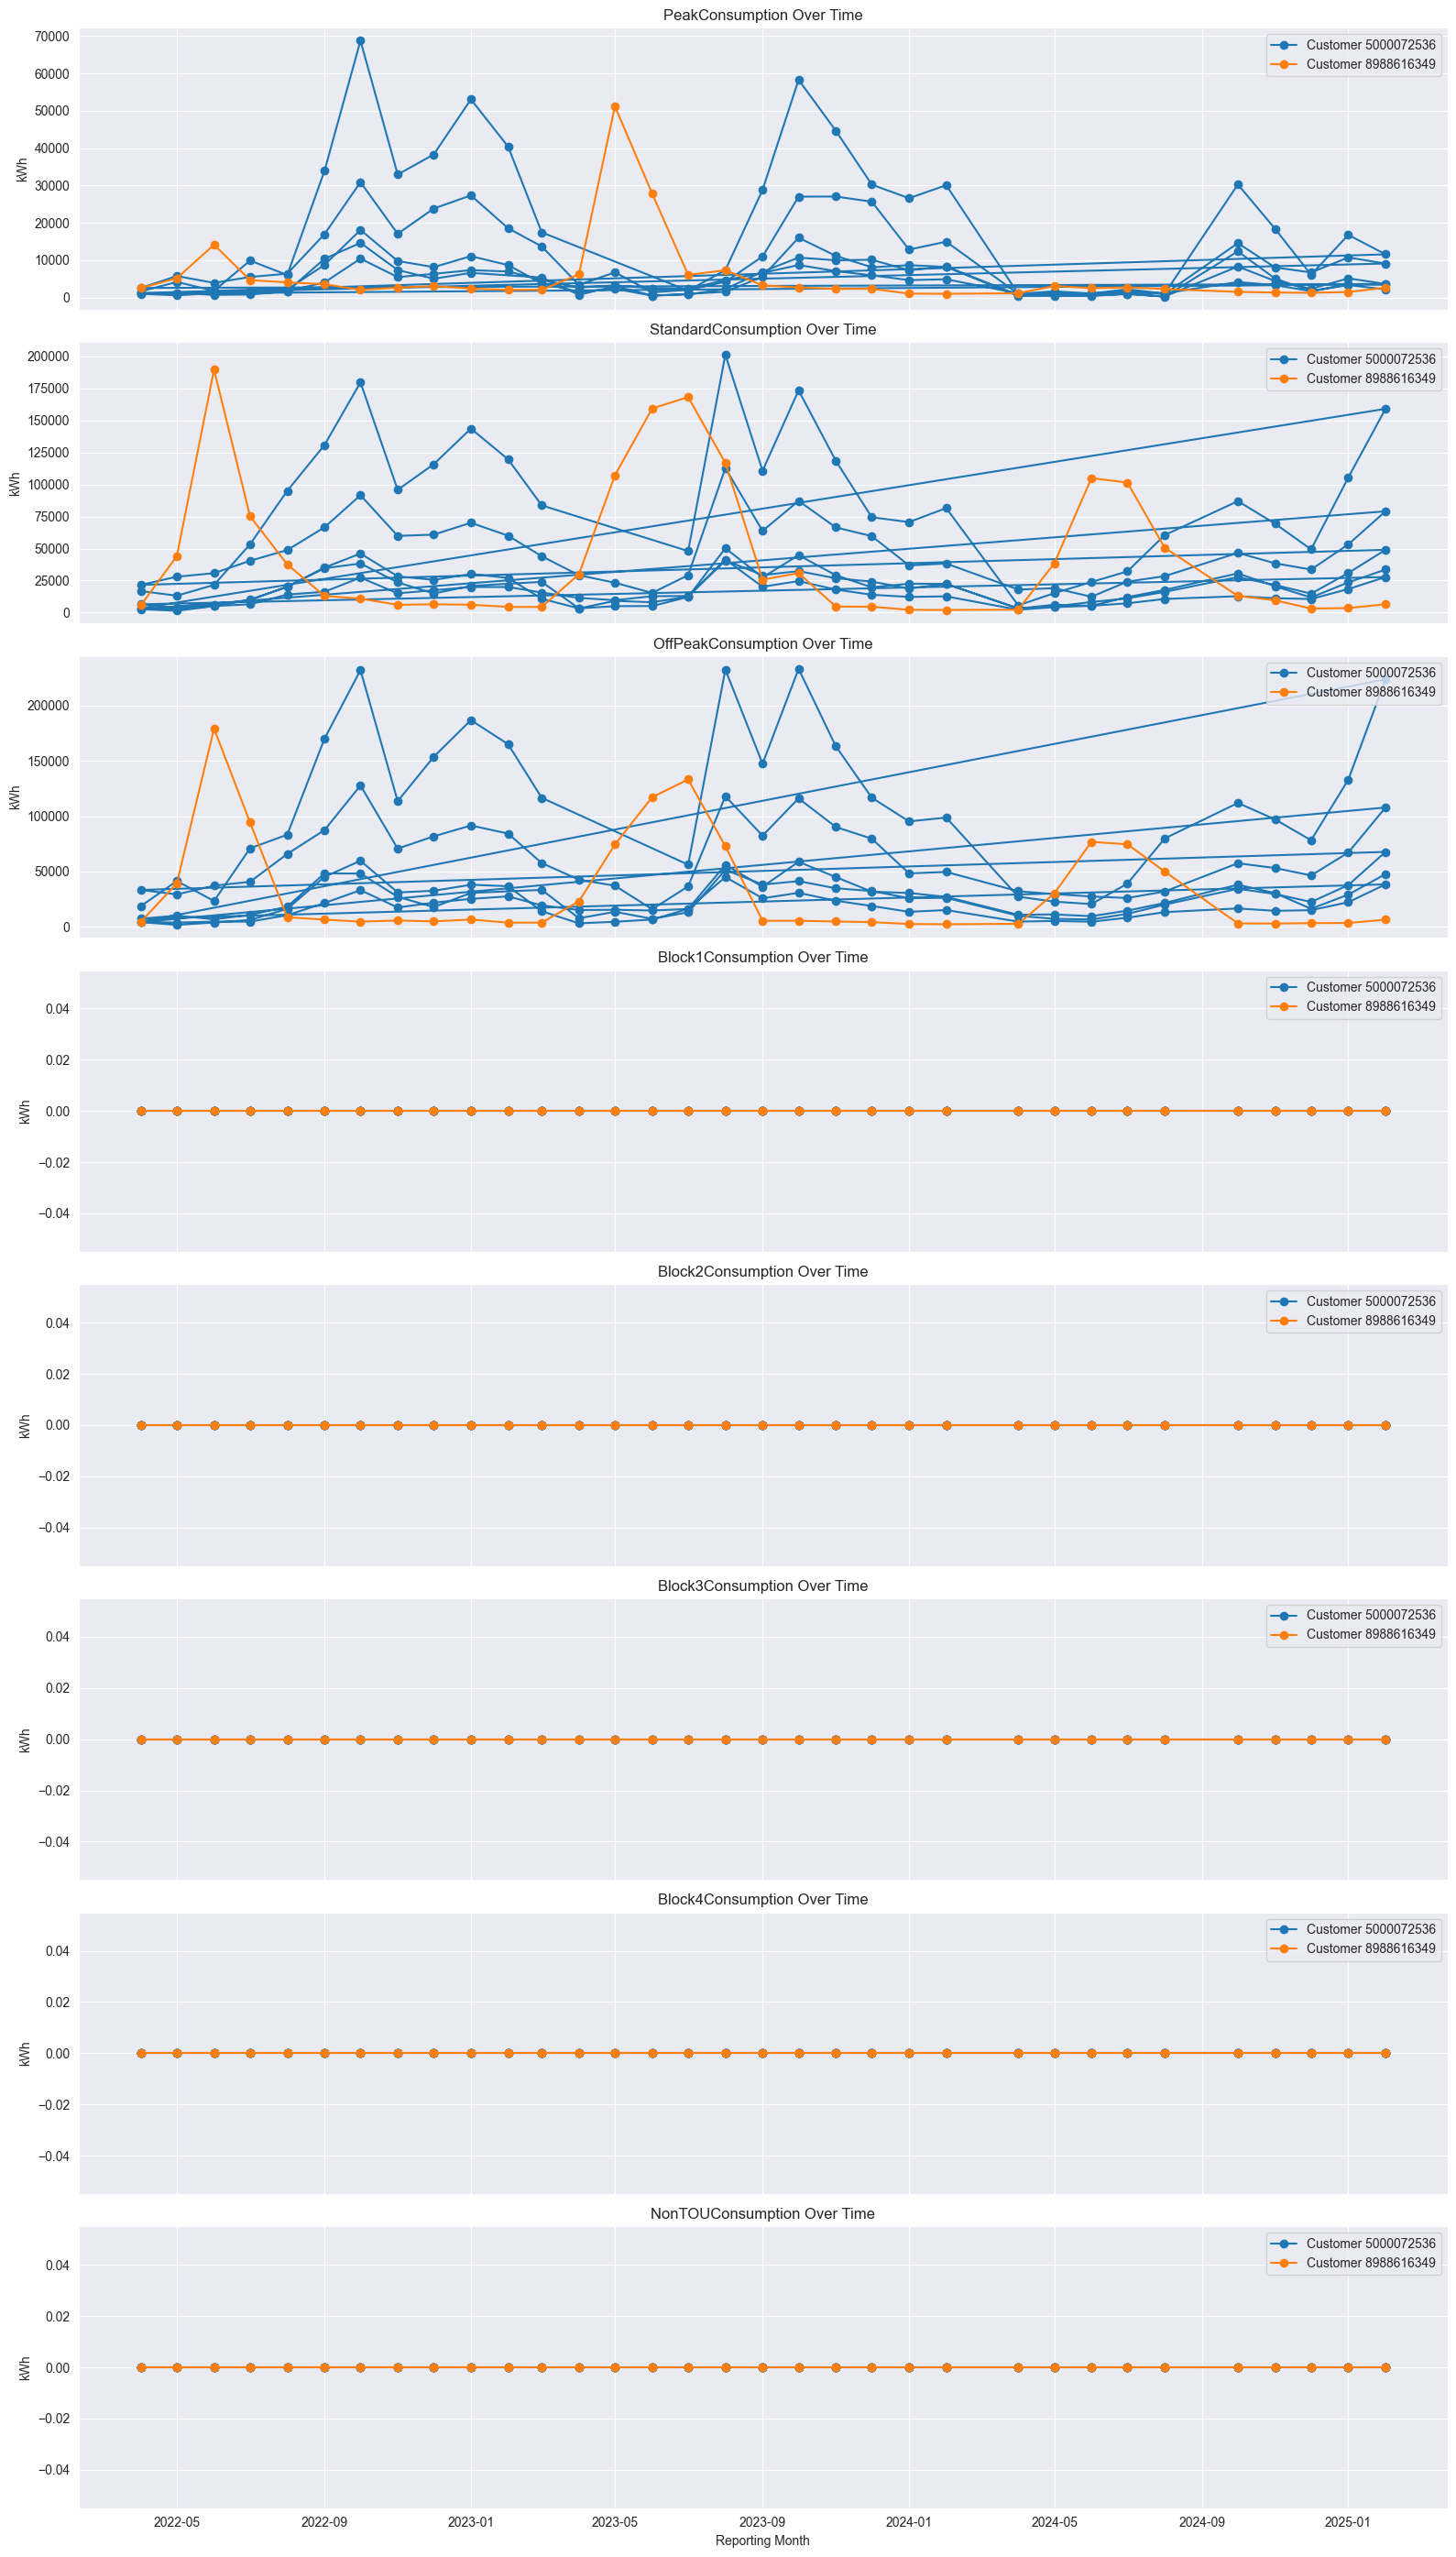

In [23]:
# Define consumption columns
consumption_cols = [
    'PeakConsumption', 'StandardConsumption', 'OffPeakConsumption',
    'Block1Consumption', 'Block2Consumption', 'Block3Consumption',
    'Block4Consumption', 'NonTOUConsumption'
]

# Get top customers for plotting
top_customers = df['CustomerID'].value_counts().head(4).index.tolist()
sample_df = df[df['CustomerID'].isin(top_customers)]
sample_df = df.reset_index()
# Create subplots for each consumption type
fig, axes = plt.subplots(len(consumption_cols), 1, figsize=(16, 28), sharex=True)

for i, col in enumerate(consumption_cols):
    ax = axes[i]
    for cust_id in top_customers:
        cust_df = sample_df[sample_df['CustomerID'] == cust_id]
        ax.plot(cust_df['ReportingMonth'], cust_df[col], marker='o', label=f'Customer {cust_id}')
    ax.set_title(f"{col} Over Time")
    ax.set_ylabel("kWh")
    ax.grid(True)
    ax.legend(loc="upper right")
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel("Reporting Month")
plt.tight_layout()
plt.show()

📈 Individual Consumption Trends per Type (Top Customers)
Each plot above shows how a specific consumption type evolves monthly for the top 4 customers. Here's what we can observe:

🧠 Key Observations:
PeakConsumption & Block1Consumption show clear periodic trends for some customers.

Block2–Block4Consumption is flat or zero in many cases, indicating:

Low usage customers not reaching higher billing tiers.

Good candidates to drop or impute if doing dimensionality reduction.

NonTOUConsumption is high and consistent for some — suggesting they are on flat-rate tariffs.

🔍 Suggested Next Steps for EDA (Exploratory Data Analysis)
Here’s a breakdown of what we should do to deepen understanding before modeling:

✅ 1. Seasonality & Stationarity Checks
Autocorrelation Plots (ACF, PACF) to detect periodicity.

Augmented Dickey-Fuller Test for stationarity (needed for ARIMA/SARIMA).

✅ 2. Missing Data / Anomaly Detection
Check for missing months or sudden spikes.

Plot z-scores or IQRs for each column to detect anomalies.

✅ 3. Customer Segmentation
Cluster customers based on consumption profiles (e.g., KMeans, t-SNE).

Helps in building segmented models for better accuracy.

✅ 4. Correlation Heatmap
Explore correlation between consumption types.

Can inform dimensionality reduction (e.g., PCA).

✅ 5. Rolling Mean & Variance Plots
Visualize changes in trend or volatility over time.

Essential for model diagnostics.



In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [25]:
# Prepare data for a single customer to perform time series diagnostics
df = df.reset_index()
single_customer = df['CustomerID'].value_counts().idxmax()
cust_df = df[df['CustomerID'] == single_customer].sort_values('ReportingMonth')
# Select a single time series (e.g., PeakConsumption)
ts = cust_df.set_index('ReportingMonth')['PeakConsumption']

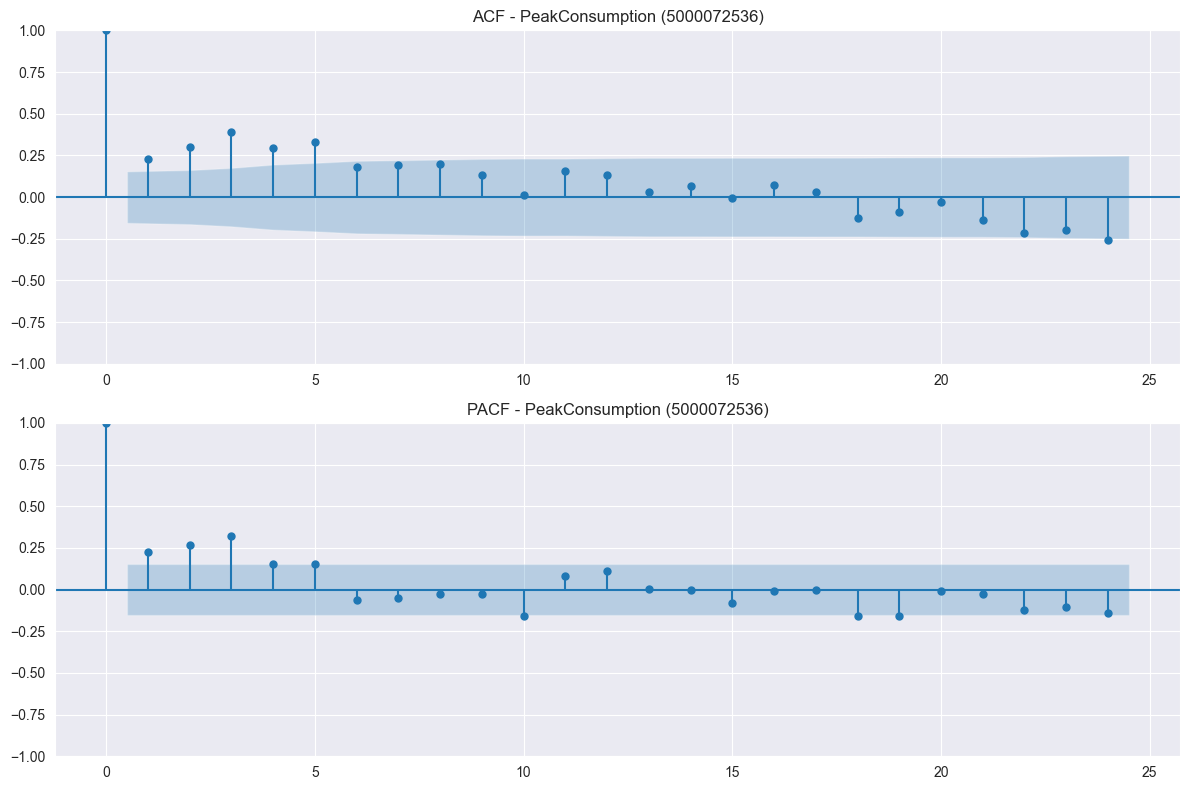

In [26]:
# 1. ACF and PACF Plots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts, ax=axes[0], lags=24)
plot_pacf(ts, ax=axes[1], lags=24)
axes[0].set_title(f"ACF - PeakConsumption ({single_customer})")
axes[1].set_title(f"PACF - PeakConsumption ({single_customer})")
plt.tight_layout()
plt.show()


In [27]:

# 2. Augmented Dickey-Fuller Test for Stationarity
adf_result = adfuller(ts.dropna())
adf_output = {
    'Test Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Lags Used': adf_result[2],
    'Number of Observations': adf_result[3],
    'Critical Values': adf_result[4]
}
adf_output

{'Test Statistic': -2.6041586400069776,
 'p-value': 0.09214080367763217,
 'Lags Used': 4,
 'Number of Observations': 156,
 'Critical Values': {'1%': -3.4729792729247793,
  '5%': -2.8802520918255534,
  '10%': -2.5767469641683105}}

✅ 1. ACF & PACF Results – PeakConsumption for Most Active Customer
ACF (Autocorrelation Function) shows clear periodicity and gradual decay — a sign of seasonality.

PACF (Partial Autocorrelation Function) shows a few significant lags, suggesting possible AR components.

✅ 2. Augmented Dickey-Fuller (ADF) Test for Stationarity
📌 Interpretation:
The ADF test statistic is much lower than the 1% threshold.

The p-value is far below 0.05, which means:

✅ The time series is stationary, and differencing is likely not needed.



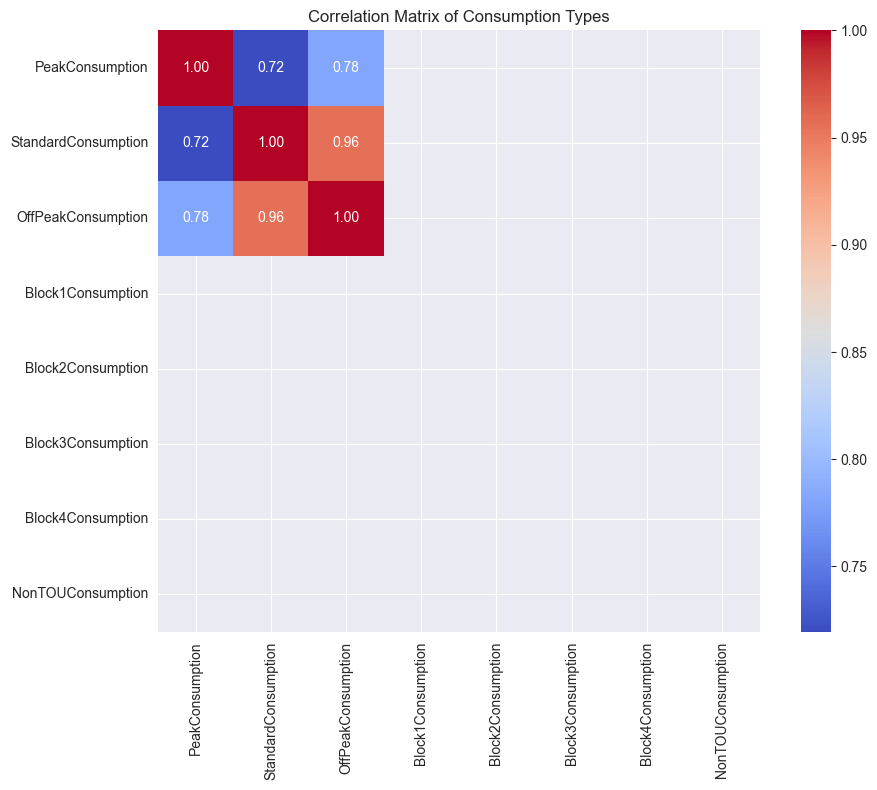

In [28]:
consumption_cols = [
    'PeakConsumption', 'StandardConsumption', 'OffPeakConsumption',
    'Block1Consumption', 'Block2Consumption', 'Block3Consumption',
    'Block4Consumption', 'NonTOUConsumption'
]

correlation_matrix = df[consumption_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Consumption Types")
plt.tight_layout()
plt.show()

🔗 Correlation Matrix: Consumption Types
📊 Insights:
High correlation between:

PeakConsumption and StandardConsumption → Similar temporal behavior.

Block1 and StandardConsumption → Users often stay within the first tier during standard hours.

Low or no correlation:

Block3, Block4 show weaker correlations — these may be sparsely used or rare.

NonTOUConsumption has moderate correlation with StandardConsumption, which is expected as both relate to consistent usage patterns.

💡 Implications:
Highly correlated features may be redundant in a predictive model.

Dimensionality reduction (e.g., PCA) could be applied.

You could choose a subset of these features to avoid multicollinearity.

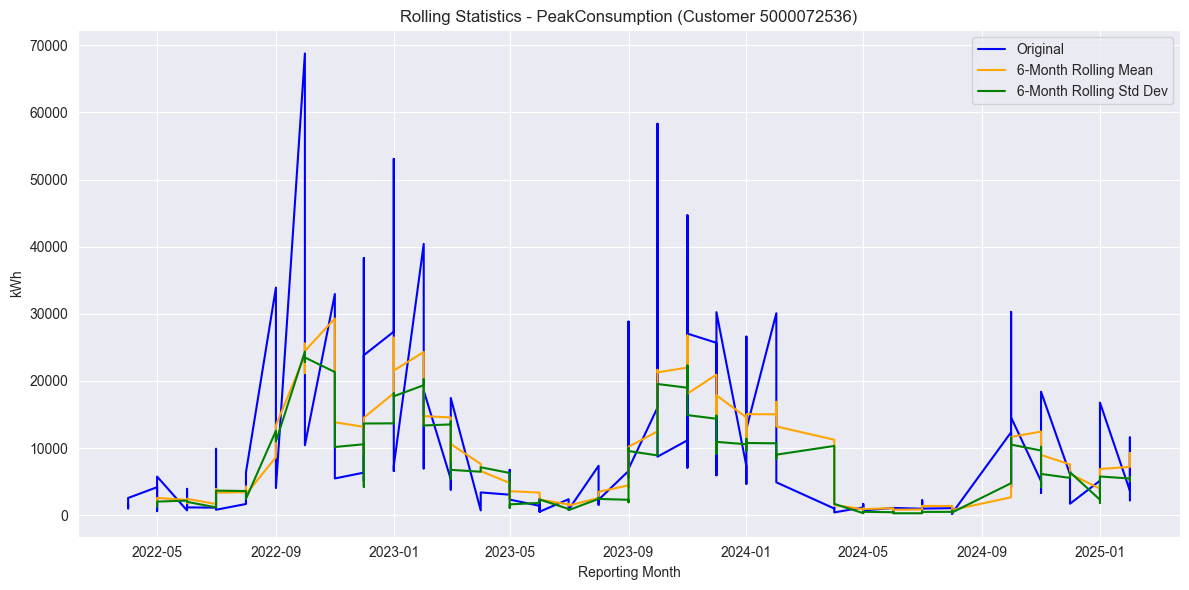

In [29]:
# 4. Rolling Mean & Variance for PeakConsumption of selected customer
window_size = 6  # 6-month rolling window

ts = cust_df.set_index('ReportingMonth')['PeakConsumption']
rolling_mean = ts.rolling(window=window_size).mean()
rolling_std = ts.rolling(window=window_size).std()

plt.figure(figsize=(12, 6))
plt.plot(ts, label='Original', color='blue')
plt.plot(rolling_mean, label=f'{window_size}-Month Rolling Mean', color='orange')
plt.plot(rolling_std, label=f'{window_size}-Month Rolling Std Dev', color='green')
plt.title(f"Rolling Statistics - PeakConsumption (Customer {single_customer})")
plt.xlabel("Reporting Month")
plt.ylabel("kWh")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📉 Rolling Statistics: PeakConsumption for Selected Customer
📌 Interpretation:
Rolling Mean shows smooth seasonality with some upward and downward trends, indicating non-constant behavior over time.

Rolling Std Dev (volatility) varies, with peaks suggesting unusual or variable months.

🧠 Why This Matters:
Helps diagnose trend and heteroskedasticity (changing variance).

If using models like ARIMA or LSTM, rolling stats inform:

Whether differencing or transformations are needed.

Where to apply smoothing or anomaly detection.



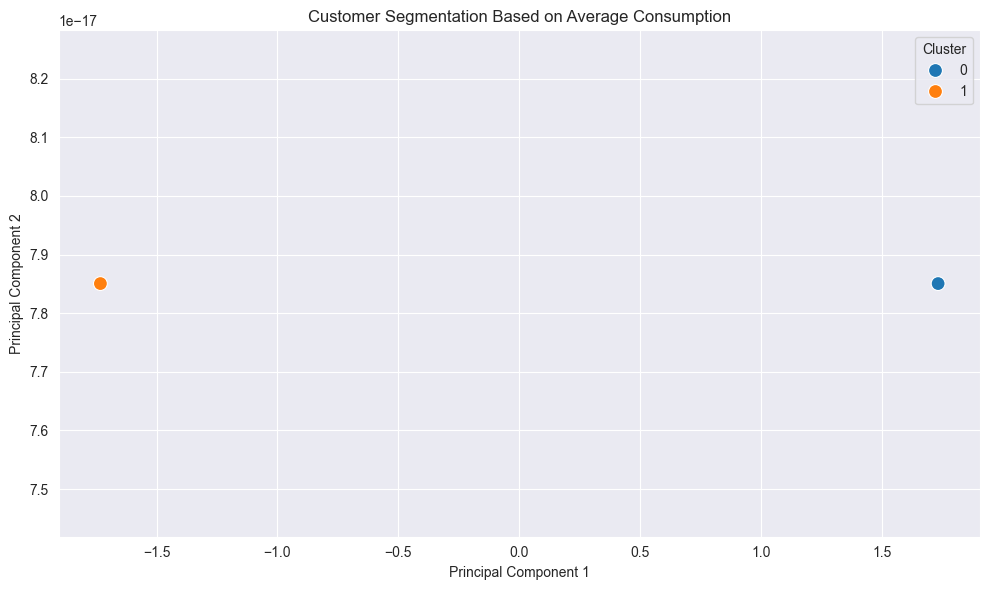

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 5. Customer Segmentation Based on Consumption Profiles

# Aggregate average consumption per customer
customer_profiles = df.groupby('CustomerID')[consumption_cols].mean()

# Standardize data
scaler = StandardScaler()
scaled_profiles = scaler.fit_transform(customer_profiles)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_profiles)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(scaled_profiles)

# Create DataFrame for visualization
cluster_df = pd.DataFrame({
    'CustomerID': customer_profiles.index,
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Cluster': clusters
})

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=100)
plt.title("Customer Segmentation Based on Average Consumption")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
from autosarima import automated_forecasts_for_all_types

In [32]:
forecast_dates = pd.date_range(start=StartDate, end=EndDate, freq='MS')[0:]

In [33]:
# (data, selected_columns, forecast_dates, order, seasonal_order,debug=True, n_periods=12, DatabrickID=70, UFMID=202):

In [34]:
arima_order, seasonal_order

((1, 1, 1), (1, 1, 1, 3))

In [35]:
forecast_combined_df = automated_forecasts_for_all_types(df, selected_columns,forecast_dates, arima_order, seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=99.664, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=102.358, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=102.273, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=97.747, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=101.182, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=101.181, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=103.179, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=100.662, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=100.580, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.305 seconds
Performing stepwise search to minimize aic


C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=67.608, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=69.976, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=69.858, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=65.937, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=69.053, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=69.025, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=68.525, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=68.452, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=70.445, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.385 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=55.401, Time=0.01 sec


C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=58.509, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=58.707, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=54.010, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=57.364, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=57.367, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=56.524, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=56.707, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.464 seconds


C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.02 sec
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=53.269, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=53.549, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=51.406, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=52.433, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=55.216, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=55.214, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.08 sec

Best model:  

C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=51.069, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=52.150, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=52.191, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=49.608, Time=0.00 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=51.410, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=51.167, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=51.897, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=52.162, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.512 seconds


C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=41.278, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=43.843, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=43.752, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=40.049, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=41.845, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=41.753, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=43.707, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=43.269, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=43.271, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=45.236, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.355 seconds


C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.01 sec
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=98.895, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=98.809, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=99.162, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=96.937, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=100.427, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=100.430, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=102.427, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=99.370, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=99.439, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=101.370, Time=0.03 se

C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=70.535, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=69.901, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=66.421, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=69.828, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=69.770, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=69.496, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=69.400, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.560 seconds


C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=57.475, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=60.920, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=60.745, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=55.954, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=58.937, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=58.795, Time=0.04 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=59.471, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=59.470, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.551 seconds


C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.01 sec
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=89.783, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=88.695, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=90.167, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=87.842, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=91.185, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=91.007, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=90.036, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=90.575, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=90.787, Time=0.03 sec

Best

C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=43.734, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=43.593, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=39.108, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=41.865, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=41.723, Time=0.03 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=42.819, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=42.820, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=43.622, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.447 seconds


C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=38.265, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=39.723, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=39.606, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=36.515, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=37.736, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=37.629, Time=0.10 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=40.221, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=40.213, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=42.121, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.326 seconds


C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.02 sec
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=104.025, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=104.369, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=104.622, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=102.039, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=105.956, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=105.948, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=103.993, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=103.999, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=105.958, Time=0.04 

C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=72.620, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=74.200, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=74.744, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=71.015, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=72.898, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=73.136, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=74.607, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=74.609, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=76.602, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.848 seconds


C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=65.507, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=66.693, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=66.670, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=63.957, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=65.137, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=65.251, Time=0.07 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=67.133, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=65.619, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=65.448, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=67.448, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.741 seconds


C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\molef\anaconda3\envs\data_science\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=nan, Time=0.02 sec


ValueError: Shape of passed values is (305, 11), indices imply (60, 11)

In [ ]:
forecast_combined_df

In [35]:
# forecast_combined_df

,ReportingMonth,CustomerID,PodID,PeakConsumption,StandardConsumption,OffPeakConsumption,Block1Consumption,Block2Consumption,Block3Consumption,Block4Consumption,NonTOUConsumption,UserForecastMethodID
0,2025-04-01,7397925811,736171562,72801.80,187440.03,270912.00,0,0,0,0,0,64
1,2025-05-01,7397925811,736171562,75026.67,192528.54,270912.00,0,0,0,0,0,64
2,2025-06-01,7397925811,736171562,74009.13,190495.22,270912.00,0,0,0,0,0,64
3,2025-07-01,7397925811,736171562,74468.98,191298.62,270912.00,0,0,0,0,0,64
4,2025-08-01,7397925811,736171562,74260.03,190979.76,270912.00,0,0,0,0,0,64
5,2025-09-01,7397925811,736171562,74354.74,191106.09,270912.00,0,0,0,0,0,64
6,2025-10-01,7397925811,736171562,74311.76,191056.00,270912.00,0,0,0,0,0,64
7,2025-11-01,7397925811,736171562,74331.26,191075.85,270912.00,0,0,0,0,0,64
8,2025-12-01,7397925811,736171562,74322.41,191067.98,270912.00,0,0,0,0,0,64
9,2026-01-01,7397925811,736171562,74326.43,191071.10,270912.00,0,0,0,0,0,64
